In [1]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.whole_brain_dataset import MRISegmentationDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.base_models.kiUNets import KiUNet, KiUNetWithTranspose, KiUNet3D

# augmentation
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.tversky_loss import TverskyLoss
from trustworthai.utils.losses_and_metrics.misc_metrics import IOU
from trustworthai.utils.losses_and_metrics.dice import dice
from torch.nn import BCELoss, MSELoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper, get_trainer

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary

### Set the seed

In [2]:
torch.manual_seed(3407) # see this absolute meme of a paper: https://arxiv.org/pdf/2109.08203.pdf
torch.cuda.manual_seed_all(3407)

### define datasets and dataloaders

In [3]:
#root_dir_wmh = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/WMH_challenge_dataset"
root_dir = "/disk/scratch/s2208943/data"

In [4]:
# augmentation definintion
CROP_SIZE = (224,160) # 192 perfect for singapore and utrecht but not for ge3t which is a different shape. 
                    # 192 is divisible by 2 6 times (3*2^6 = 192) but 224 and 160 still 5 times so won't cause any problems hopefully.
WMH_LABEL = 1
IMG_DEPTH = 8 # 15 # number of z stacks to select

# SINGAPORE_zstartend = (30,78)
# WMH_CHAL_zstartend = (0,48)

FINAL_OUT_SIZE = (112,80)#(168, 120) # 112, 80

domain_dcrop_map = {
    "Singapore":(0,48),
    "Utrecht":(0,48),
    "GE3T":(30,78),
    "domainA":(0,40),
    "domainB":(5,48),
    "domainC":(5,48), # I do not think the 'domain C' images have been correctly identified
    "domainD":(7,52)
}

def get_transforms(dcrop_bounds):
    start_dcrop, end_dcrop = dcrop_bounds
    transforms = PairedCompose([
        PairedCentreCrop(CROP_SIZE),                  # cut out the centre square
        CropZDim(IMG_DEPTH, start_dcrop, end_dcrop),  # crop the z stack
        LabelSelect(WMH_LABEL),
        RandomFlip(p=0.5, orientation="horizontal"),
        GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(.1,3.)),
        RandomAffine(p=0.2, degrees=5),
        RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.), output_size=FINAL_OUT_SIZE)
    ])
    return transforms

In [5]:
# define paths to each domain
domains = ["Singapore", "Utrecht", "GE3T", "domainA", "domainB", "domainC", "domainD"]
domains = [os.path.join(root_dir, d) for d in domains]

In [6]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size])
    return train, val, test

In [7]:
# load datasets
datasets_domains = [
    MRISegmentationDataset(
        dom, 
        transforms=get_transforms(domain_dcrop_map[dom.split(os.path.sep)[-1]])
    ) 
    for dom in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [8]:
len(train_dataset), len(val_dataset), len(test_dataset)

(219, 61, 30)

In [9]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [10]:
img, label = datasets_domains[3][0]

In [11]:
#img, label = train_dataset[3]

In [12]:
img.shape

torch.Size([2, 8, 112, 80])

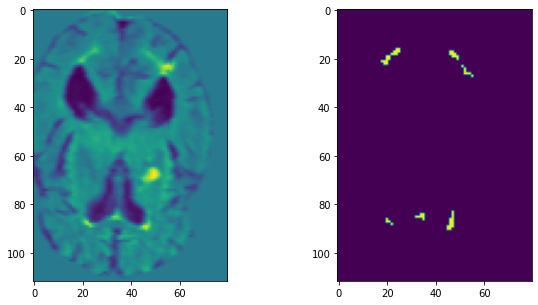

In [13]:
# plot an image
#img, label = train_dataset[10]
img, label = datasets_domains[6][0]
islice = 4
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img.numpy()[0,islice,:,:])
plt.subplot(1,2,2)
plt.imshow((label.numpy()==1)[0,islice,:,:])

### define model

In [14]:
model = KiUNet3D(encoder_layers=[16,32,64], 
                 decoder_layers=[32,16,8], 
                 encoderf1_layers=[16,32,64], 
                 decoderf1_layers=[32,16,8], 
                 intere_layers=[16,32,64], 
                 interd_layers=[32,16],
                 in_channels=2, 
                 out_channels=1, 
                 kernel_size=3,
                 dropout_p=0.1)

In [15]:
summary(model)

Layer (type:depth-idx)                   Param #
KiUNet3D                                 --
├─ModuleList: 1-1                        --
│    └─SimpleBlock: 2-1                  --
│    │    └─Conv3d: 3-1                  880
│    │    └─BatchNorm3d: 3-2             32
│    │    └─Dropout3d: 3-3               --
│    └─SimpleBlock: 2-2                  --
│    │    └─Conv3d: 3-4                  13,856
│    │    └─BatchNorm3d: 3-5             64
│    │    └─Dropout3d: 3-6               --
│    └─SimpleBlock: 2-3                  --
│    │    └─Conv3d: 3-7                  55,360
│    │    └─BatchNorm3d: 3-8             128
│    │    └─Dropout3d: 3-9               --
├─ModuleList: 1-2                        --
│    └─SimpleBlock: 2-4                  --
│    │    └─Conv3d: 3-10                 55,328
│    │    └─BatchNorm3d: 3-11            64
│    │    └─Dropout3d: 3-12              --
│    └─SimpleBlock: 2-5                  --
│    │    └─Conv3d: 3-13                 13,840
│    │   

### define fitter

In [16]:
loss = TverskyLoss()
logging_metrics = [("dice",dice), ("IOU",IOU)]
fitter = StandardLitModelWrapper(model,
                                 train_dataloader,
                                 test_dataloader,
                                 val_dataloader,
                                 None,
                                 loss,
                                 logging_metrics
                                )

In [17]:
#checkpoint_dir = "/media/benp/NVMEspare/model_data/trustworthai/initial_tests"
checkpoint_dir = "/disk/scratch/s2208943/results/"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

precision = None
precision = 16
trainer = get_trainer(checkpoint_dir, accelerator="gpu", devices=1, max_epochs=400,
                      strategy=strategy, precision=precision
                     )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(fitter, train_dataloader, val_dataloader)

Missing logger folder: /disk/scratch/s2208943/results/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type        | Params
--------------------------------------
0 | model | KiUNet3D    | 646 K 
1 | loss  | TverskyLoss | 0     
--------------------------------------
646 K     Trainable params
0         Non-trainable params
646 K     Total params
1.293     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.973


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.969


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.968


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.966


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### test size on gpu

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
mcuda = model.to("cuda")

In [ ]:
y_hat = mcuda(batch[0].to("cuda"))

In [ ]:
batch[0][0].shape

In [ ]:
plt.imshow(batch[0][0].numpy()[0,3,:,:])

In [ ]:
y_hat.shape

In [ ]:
plt.imshow(y_hat.detach().cpu()[0].numpy()[0,3,:,:])